# Data Processing
Data was collected over 16 trials for each of two function defined ramps. In this notebook, the data is averaged into position vs. time data that can be compared to theoretical data. The data files are tab delimited and simply named by their trial number + ".txt".

### Begin by loading the raw data into lists of numpy arrays:

In [1]:
import numpy as np

In [2]:
# A function to load individual trial data sets into a list of numpy arrays:
def load_raw_data(path):
    raw_data_set = list()
    for i in range(16):
        
        # The trial numbers start with 1, but the loop index starts with 0:
        trial_number = i + 1
        file_path = path + str(trial_number) + '.txt'
        
        # Load the tab delimited data, skipping the first 6 rows containing string data:
        raw_data = np.loadtxt(file_path, delimiter='\t', skiprows=6)
        raw_data_set.append(raw_data)
        
    return raw_data_set

In [3]:
ramp1_raw_data = load_raw_data('raw data/ramp1 trials/')
ramp2_raw_data = load_raw_data('raw data/ramp2 trials/')

### Find the smallest trial in each group of trials:
That is, Find the trial for the ramp1 and ramp2 experiments that contain the fewest data points. There can only be this many data points in the average data that is the end goal.

In [4]:
# Function to return the number of data points in the smallest experiment given a list of numpy arrays:
def min_data_points(data_set):
    
    # Check note the number of elements down the rows of each data file:
    num_data_points = list()
    for trial_num in range(16):
        num_data_points.append(np.size(data_set[trial_num], axis=0))
    
    # Return the minimum number of data points for the given set:
    min_data = np.min(num_data_points)
    return min_data

In [5]:
# Use the function defined above to determine the minimum number of data points for the ramp1 and ramp2 data:
min_ramp1_data = min_data_points(ramp1_raw_data)
min_ramp2_data = min_data_points(ramp2_raw_data)

### Resolve the time and position data for each data set as numpy arrays:
All of the trials should start at $t=0$, and there should only be as many sample times as the smallest trials determined previously. Also, the origin for the x position data needs to be moved to the far left of the ramp in both data sets, and negative positions in the ramp2 data set should be made positive. If the origin is at $x_{0}=150$ but is shifted to $x=0$, then the new coordinate of a point is shifted by $\Delta x = x - x_{0}$. Negative coordinates that result from this process are easily fixed. In cleaning up the data in these ways, they are converted from their current form as lists of numpy arrays to pure numpy arrays, which will simplify later operations.

In [6]:
# Function to resolve normalized time data for a data set:
def t_to_numpy(num_data_points, data_set):
    
    # The first column of the data set input is just the first trial of the experiment:
    experiment_data = data_set[0]
    
    # The first column of the data from a single experiment is the raw sample times:
    raw_sample_times = experiment_data[:num_data_points, 0]
    
    # This time data should be normalized so it starts at t=0:
    start_time = raw_sample_times[0]
    normalized_sample_times = raw_sample_times - start_time
    return normalized_sample_times

In [7]:
# This function converts the list of numpy arrays to a numpy array in which each column contains x data from different
# trials:
def x_to_numpy(num_data_points, data_set):
    
    # Preallocate a numpy array to contain the raw x data for a given data set:
    raw_x_data = np.empty((num_data_points, 16))
    
    # Append the x data from a given data set to their own column in a new numpy array:
    for trial_num in range(16):
        trial_data = data_set[trial_num]
        trial_x_data = trial_data[:, 1] # The second column of a data file is the x data.
        raw_x_data[:, trial_num] = trial_x_data[:num_data_points]
        
    # Now the process of normalizing the x data begins. Define delta x based on the length of the ramps:
    delta_x = -150

    # Initially make the position data positive:
    raw_x_data = np.abs(raw_x_data)

    # Shift the coordinates so they represent a distance from a left origin:
    raw_x_data += delta_x

    # Make the position data positive again:
    raw_x_data = np.abs(raw_x_data)
    
    return raw_x_data

In [8]:
# Use the functions defined above to resolve the normalized time data and raw x data for the ramp1 and ramp2 experiments:
ramp1_t = t_to_numpy(min_ramp1_data, ramp1_raw_data)
ramp1_x = x_to_numpy(min_ramp1_data, ramp1_raw_data)

ramp2_t = t_to_numpy(min_ramp2_data, ramp2_raw_data)
ramp2_x = x_to_numpy(min_ramp2_data, ramp2_raw_data)

### Construct average position and error for each ramp:
The position data is averaged and a 95% confidence interval is computed for both ramps in this step.

In [9]:
# Average the position data:
ramp1_x_avg = np.mean(ramp1_x, axis=1)
ramp2_x_avg = np.mean(ramp2_x, axis=1)

# Compute the 99% confidence interval for each data point:
from scipy.stats import t

df = 15 # n = 16, df = n - 1
t_stat = t.ppf(0.975, df) # For 99% confidence, two-tailed.

ramp1_std = np.std(ramp1_x, axis=1)
ramp1_st_err = ramp1_std/np.sqrt(16)
ramp1_ci = t_stat * ramp1_st_err

ramp2_std = np.std(ramp2_x, axis=1)
ramp2_st_err = ramp2_std/np.sqrt(16)
ramp2_ci = t_stat * ramp2_st_err

### Concatenate and save the processed data to files for comparison to theoretical data:

In [10]:
ramp1_data = np.stack((ramp1_t, ramp1_x_avg, ramp1_ci), axis=1)
ramp2_data = np.stack((ramp2_t, ramp2_x_avg, ramp2_ci), axis=1)

np.save('processed data/ramp1_time_vs_avg_position.npy', ramp1_data)
np.save('processed data/ramp2_time_vs_avg_position.npy', ramp2_data)

### Visualize the x position of the rolling object over time:

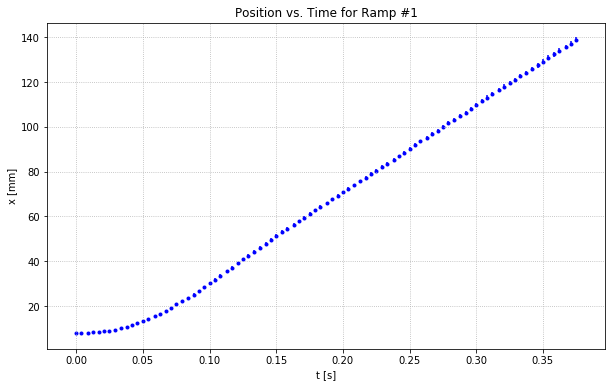

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the time-position data for ramp #1:
fig, axes = plt.subplots(figsize=[10, 6])

axes.set_title('Position vs. Time for Ramp #1')
axes.set_ylabel('x [mm]')
axes.set_xlabel('t [s]')
axes.scatter(ramp1_t, ramp1_x_avg, marker='.', color='blue')
axes.errorbar(ramp1_t, ramp1_x_avg, yerr=ramp1_ci, ecolor='blue', fmt='none')
axes.grid(linestyle=':')

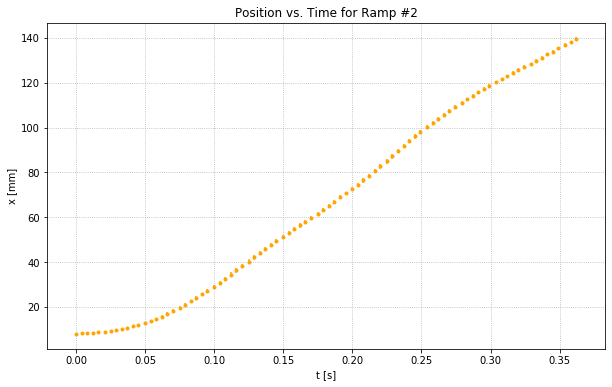

In [12]:
# Plot the time-position data for ramp #2
fig, axes = plt.subplots(figsize=[10, 6])

axes.set_title('Position vs. Time for Ramp #2')
axes.set_ylabel('x [mm]')
axes.set_xlabel('t [s]')
axes.scatter(ramp2_t, ramp2_x_avg, marker='.', color='orange')
axes.errorbar(ramp2_t, ramp2_x_avg, yerr=ramp2_ci, ecolor='orange', fmt='none')
axes.grid(linestyle=':')